<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/05_reglin_3.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(group-comp-notebook)=
# Confronto tra le medie di due gruppi

Nel capitolo {ref}`two_groups_comparison_notebook`, abbiamo esaminato come effettuare l'inferenza sulla differenza tra le medie di due campioni indipendenti usando un modello bayesiano. In questo approccio, trattiamo i due gruppi come entità separate e calcoliamo direttamente la differenza tra le loro medie. Per fare ciò, utilizziamo distribuzioni a priori per i parametri del modello, come le deviazioni standard e le medie, e poi aggiorniamo queste distribuzioni a posteriori utilizzando i dati osservati.

Tuttavia, possiamo ottenere lo stesso risultato utilizzando un modello di regressione. Invece di calcolare direttamente la differenza tra le medie dei due gruppi, includiamo una variabile "dummy" nel modello di regressione. Questa variabile "dummy" ci permette di rappresentare in modo binario l'appartenenza dei dati ai gruppi: assegniamo il valore 0 a un gruppo di riferimento e il valore 1 al gruppo di confronto. Successivamente, il modello di regressione stima un parametro di regressione associato alla variabile "dummy", che rappresenta proprio la differenza tra le medie dei due gruppi. Quindi, la variabile "dummy" funge da indicatore per il gruppo e ci consente di ottenere la stima della differenza tra le medie dei due gruppi in modo efficiente.

Entrambi gli approcci sono validi per l'inferenza sulla differenza tra le medie dei due gruppi indipendenti, ma il modello di regressione offre una maggiore flessibilità e possibilità di espansione. Infatti, possiamo includere ulteriori variabili esplicative nel modello di regressione per comprendere meglio i fattori che influenzano il risultato di interesse. Questa flessibilità è particolarmente utile quando vogliamo esplorare come altre variabili possano contribuire alla differenza tra le medie dei gruppi o quando desideriamo considerare più fattori simultaneamente.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import statistics as st
import arviz as az
import bambi as bmb
import pymc as pm
import pymc.sampling_jax
from pymc import HalfNormal, Model, Normal, sample
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc9_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Regressione bayesiana per due gruppi indipendenti

Nel contesto bayesiano, il modello di regressione può essere formulato nel modo seguente:

$$
\begin{align*}
y_i & \sim \mathcal{N}(\mu_i, \sigma), \\
\mu_i & = \alpha + \beta x_i.
\end{align*}
$$

In questa rappresentazione:

- $ \alpha $ agisce come intercetta,
- $ \beta $ è il coefficiente angolare o la pendenza,
- $ \sigma $ è l'errore standard associato alle osservazioni.

Nel caso specifico, la variabile $ x $ è una variabile indicatrice che assume i valori 0 o 1. Per il gruppo identificato da $ x = 0 $, il modello si riduce a:

$$
\begin{align*}
y_i & \sim \mathcal{N}(\mu_i, \sigma), \\
\mu_i & = \alpha.
\end{align*}
$$

Questo implica che $ \alpha $ rappresenta la media del gruppo codificato come $ x = 0 $.

Per il gruppo contrassegnato da $ x = 1 $, il modello diventa:

$$
\begin{align*}
y_i & \sim \mathcal{N}(\mu_i, \sigma), \\
\mu_i & = \alpha + \beta.
\end{align*}
$$

In termini dei parametri del modello, la media per il gruppo codificato con $ x = 1 $ è rappresentata da $ \alpha + \beta $. In questa configurazione, $ \beta $ indica la differenza tra la media del gruppo con $ x = 1 $ e quella del gruppo con $ x = 0 $. Di conseguenza, l'analisi della differenza tra le medie dei due gruppi può essere effettuata attraverso l'inferenza sul parametro $ \beta $. In sintesi, per confrontare le medie dei due gruppi indipendenti, si può esaminare la distribuzione a posteriori di $ \beta $.

## Un esempio illustrativo

Esaminiamo nuovamente i dati relativi al quoziente di intelligenza dei bambini le cui madri hanno completato oppure no la scuola superiore. Ci poniamo il problema di replicare i risultati ottenuti in precedenza usando l'analisi di regressione.

Leggiamo i dati:

In [3]:
kidiq = pd.read_stata("../data/kidiq.dta")
kidiq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


In [4]:
kidiq.groupby(["mom_hs"]).size()

mom_hs
0.0     93
1.0    341
dtype: int64

Ci sono 93 bambini la cui madre non ha completato le superiori e 341 bambini la cui madre ha ottenuto il diploma di scuola superiore.

In [4]:
summary_stats = [st.mean, st.stdev]
kidiq.groupby(["mom_hs"]).aggregate(summary_stats)

kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

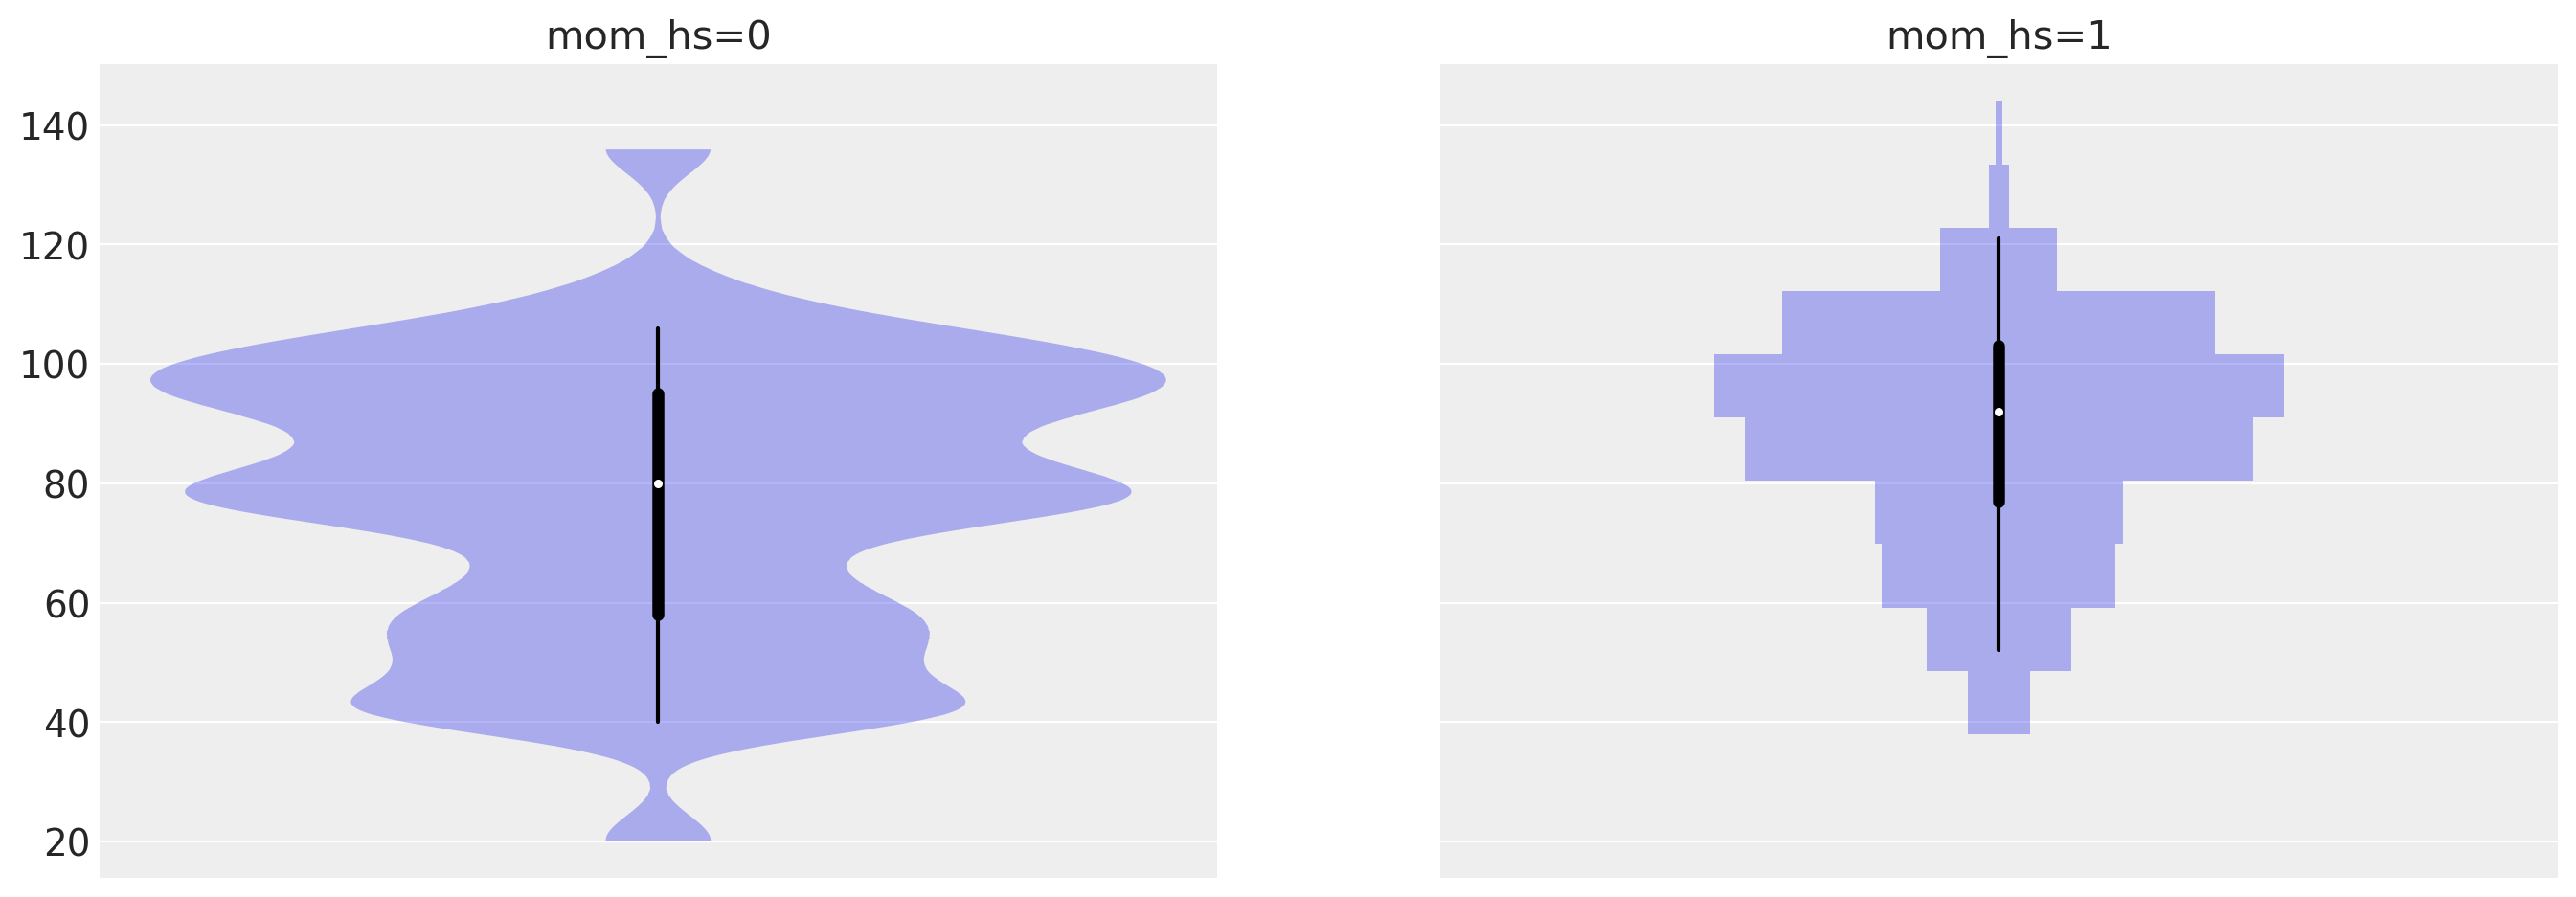

In [5]:
az.plot_violin(
    {
        "mom_hs=0": kidiq.loc[kidiq.mom_hs == 0, "kid_score"],
        "mom_hs=1": kidiq.loc[kidiq.mom_hs == 1, "kid_score"],
    }
);

Iniziamo l'inferenza statistica sulla differenza tra le medie dei due gruppi utilizzando `bambi`. Questo pacchetto offre una sintassi semplice per formulare il modello bayesiano di interesse. Un altro vantaggio è che `bambi` selezionerà automaticamente le distribuzioni a priori appropriate per i parametri del modello, rendendo il processo più intuitivo.

Il modello di regressione sopra descritto si scrive nel modo seguente.

In [6]:
mod = bmb.Model("kid_score ~ mom_hs", kidiq)

Effettuiamo il campionamento.

In [7]:
results = mod.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

Compiling...
I0000 00:00:1699423678.982561       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
Compilation time = 0:00:03.146411
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:02<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 707.63it/s]
Sampling time = 0:00:03.380946
Transforming variables...
Transformation time = 0:00:00.117506
Computing Log Likelihood...
Log Likelihood time = 0:00:00.217532


Possiamo ispezionare le proprietà del modello nel modo seguente.

In [27]:
mod

       Formula: kid_score ~ mom_hs
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 86.7972, sigma: 110.1032)
            mom_hs ~ Normal(mu: 0.0, sigma: 124.2132)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Le distribuzioni a priori utilizzate di default dal modello possono essere visualizzate nel modo seguente.

Sampling: [Intercept, kid_score_sigma, mom_hs]


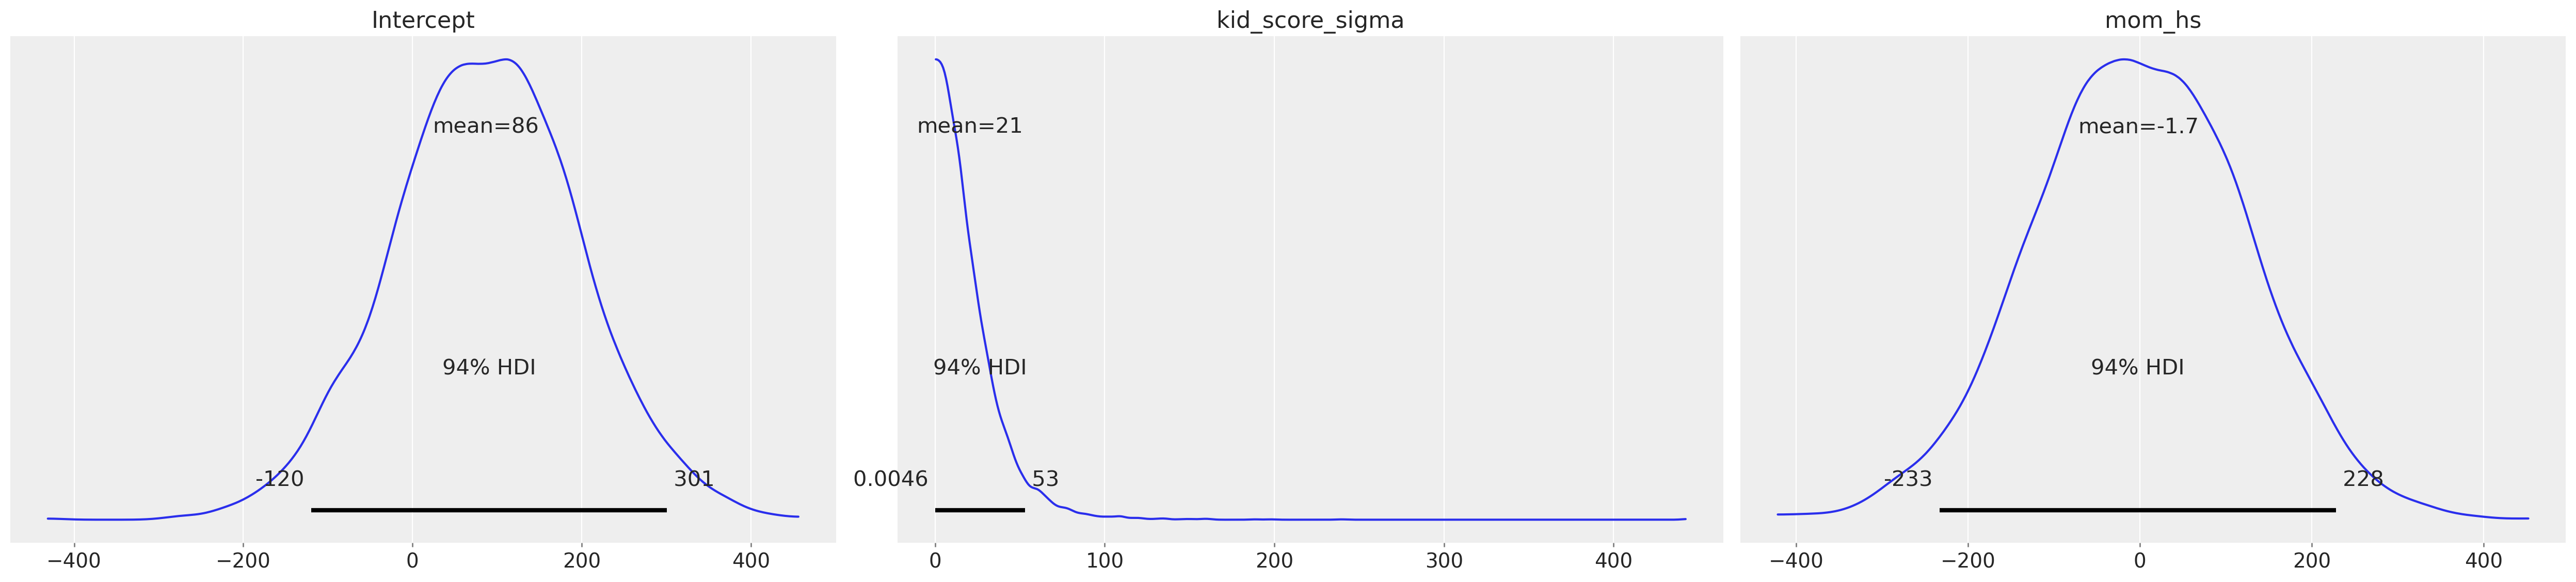

In [8]:
mod.plot_priors();

Per ispezionare il nostro posteriore e il processo di campionamento possiamo utilizzare `az.plot_trace()`. L'opzione `kind='rank_vlines'` ci fornisce una variante del grafico di rango che utilizza linee e punti e ci aiuta a ispezionare la stazionarietà delle catene. Poiché non c'è un modello chiaro o deviazioni serie dalle linee orizzontali, possiamo concludere che le catene sono stazionarie.

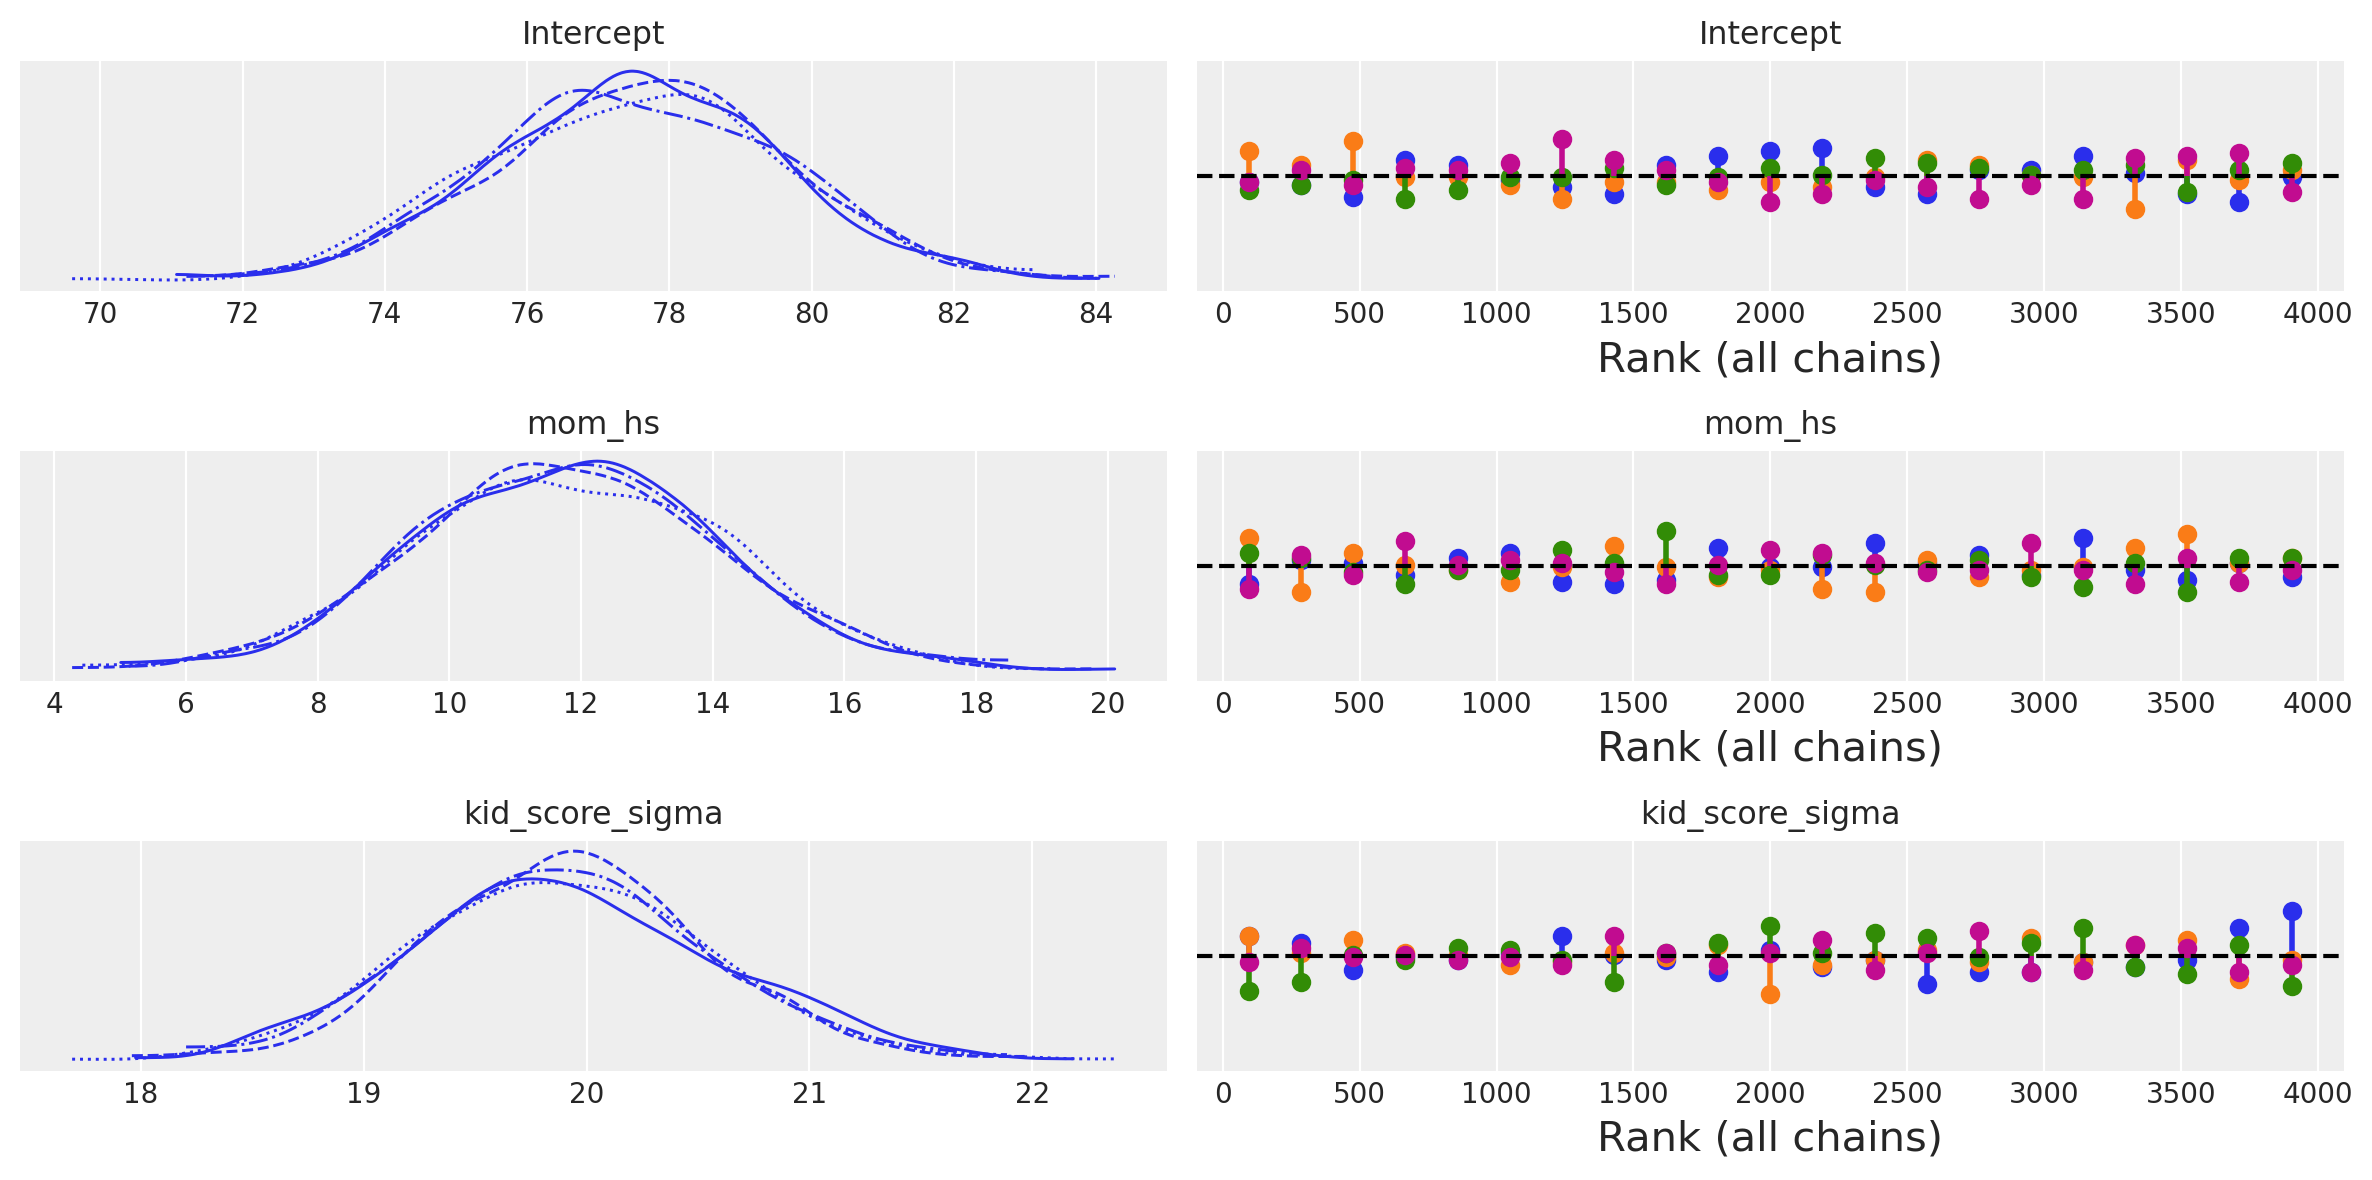

In [9]:
az.plot_trace(results, kind="rank_vlines")
plt.tight_layout()

In [9]:
az.summary(results, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,77.59,2.03,73.94,81.50,0.03,0.02,4133.18,2950.03,1.0
mom_hs,11.71,2.35,7.42,16.23,0.04,0.03,4107.57,2998.06,1.0
kid_score_sigma,19.91,0.70,18.66,21.28,0.01,0.01,3854.94,3108.51,1.0


Il parametro "Intercept" rappresenta la stima a posteriori del punteggio del QI per il gruppo codificato con "mom_hs" uguale a 0. La media a posteriori di questo gruppo è di 77.6, che è praticamente identica al valore campionario corrispondente.

Il parametro "mom_hs" corrisponde alla stima a posteriori della differenza nei punteggi del QI tra il gruppo codificato con "mom_hs" uguale a 1 e il gruppo codificato con "mom_hs" uguale a 0. Anche in questo caso, la differenza a posteriori di 11.8 tra le medie dei due gruppi è molto simile alla differenza campionaria tra le medie dei due gruppi. La parte importante della tabella riguarda l'intervallo di credibilità al 94%, che è [7.5, 16.2], e che non include lo 0. Ciò significa che, con un livello di certezza soggettiva del 94%, possiamo essere sicuri che il QI dei bambini le cui madri hanno il diploma superiore sarà maggiore (in media) di almeno 7.5 punti, e tale differenza può arrivare fino a 16.2 punti, rispetto al QI dei bambini le cui madri non hanno completato la scuola superiore.

Se confrontiamo questi risultati con quelli ottenuti nel capitolo {ref}`two_groups_comparison_notebook`, notiamo che sono quasi identici. Le piccole differenze che si osservano possono essere attribuite sia all'approssimazione numerica sia al fatto che nel modello precedente abbiamo consentito deviazioni standard diverse per i due gruppi, mentre nel caso attuale abbiamo assumo la stessa variabilità per entrambi i gruppi.

Il test bayesiano di ipotesi può essere svolto, per esempio, calcolando la probabilità che $\beta_{mean\_diff} > 0$. Questa probabilità è 1, per cui concludiamo che la media del gruppo codificato con "mom_hs = 1" è maggiore della media del gruppo codificato con "mom_hs = 0". 

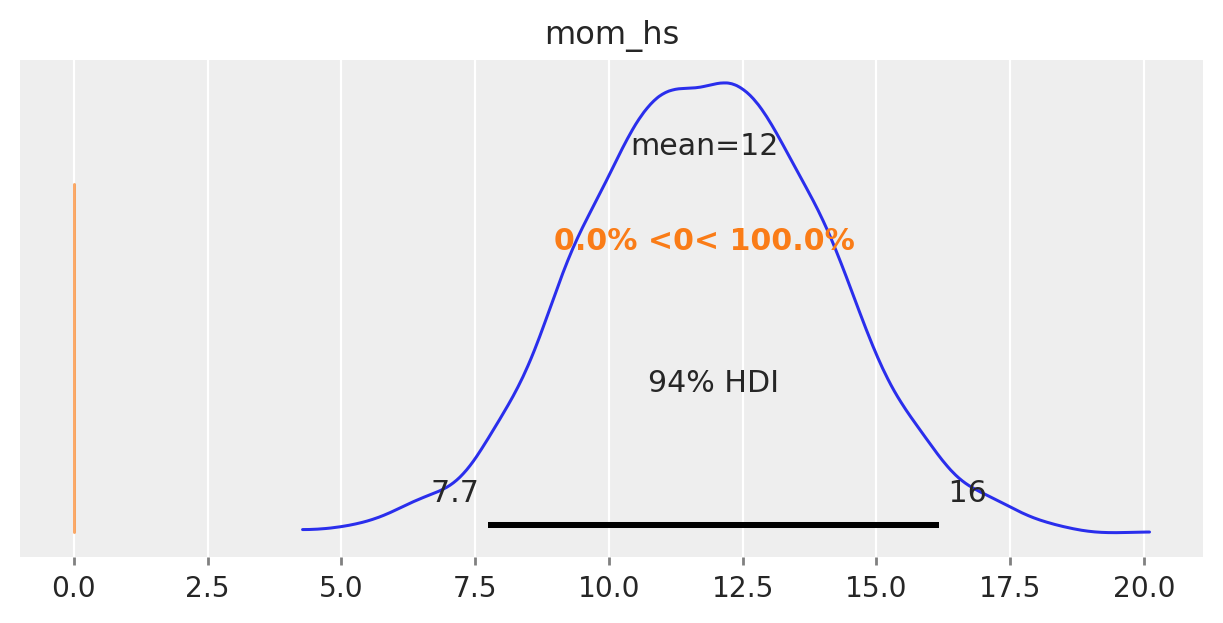

In [13]:
az.plot_posterior(results, var_names="mom_hs", ref_val=0, figsize=(6, 3));

Un valore numerico si ottiene nel modo seguente.

In [33]:
results.posterior

<xarray.Dataset>
Dimensions:          (chain: 4, draw: 1000)
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    Intercept        (chain, draw) float64 77.96 77.25 77.77 ... 79.48 76.09
    mom_hs           (chain, draw) float64 11.08 12.07 10.72 ... 8.728 13.88
    kid_score_sigma  (chain, draw) float64 18.41 21.63 18.73 ... 20.31 20.44
Attributes:
    created_at:                  2023-11-08T04:56:41.994211
    arviz_version:               0.16.1
    modeling_interface:          bambi
    modeling_interface_version:  0.12.0

In [36]:
# Probabiliy that posterior is > 0
(results.posterior["mom_hs"] > 0).mean().item()

1.0

## Parametrizzazione alternativa

Consideriamo adesso il caso in cui, per distinguere i gruppi, anziché una variabile dicotomica, con valori 0 e 1, usiamo una variabile qualitativa con i nomi dei due gruppi. Introduciamo questa nuova variabile nel data frame.

In [20]:
# Add a new column 'hs' with the categories based on 'mom_hs'
kidiq["hs"] = kidiq["mom_hs"].map({0: "not_completed", 1: "completed"})
kidiq.tail()

,kid_score,mom_hs,mom_iq,mom_work,mom_age,hs
429,94,0.0,84.877412,4,21,not_completed
430,76,1.0,92.990392,4,23,completed
431,50,0.0,94.859708,2,24,not_completed
432,88,1.0,96.856624,2,21,completed
433,70,1.0,91.253336,2,25,completed


Adattiamo il modello ai dati, usando questa nuova variabile e forziamo a zero l'intercetta che Bambi aggiunge di default al modello.

In [21]:
mod_2 = bmb.Model("kid_score ~ 0 + hs", kidiq)
results_2 = mod_2.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time = 0:00:00.534171
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1415.10it/s]
Sampling time = 0:00:01.523825
Transforming variables...
Transformation time = 0:00:00.061116
Computing Log Likelihood...
Log Likelihood time = 0:00:00.106777


Ispezionare il modello e le distribuzioni a priori.

In [45]:
mod_2

       Formula: kid_score ~ 0 + hs
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            hs ~ Normal(mu: [0. 0.], sigma: [124.2132 124.2132])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [hs, kid_score_sigma]


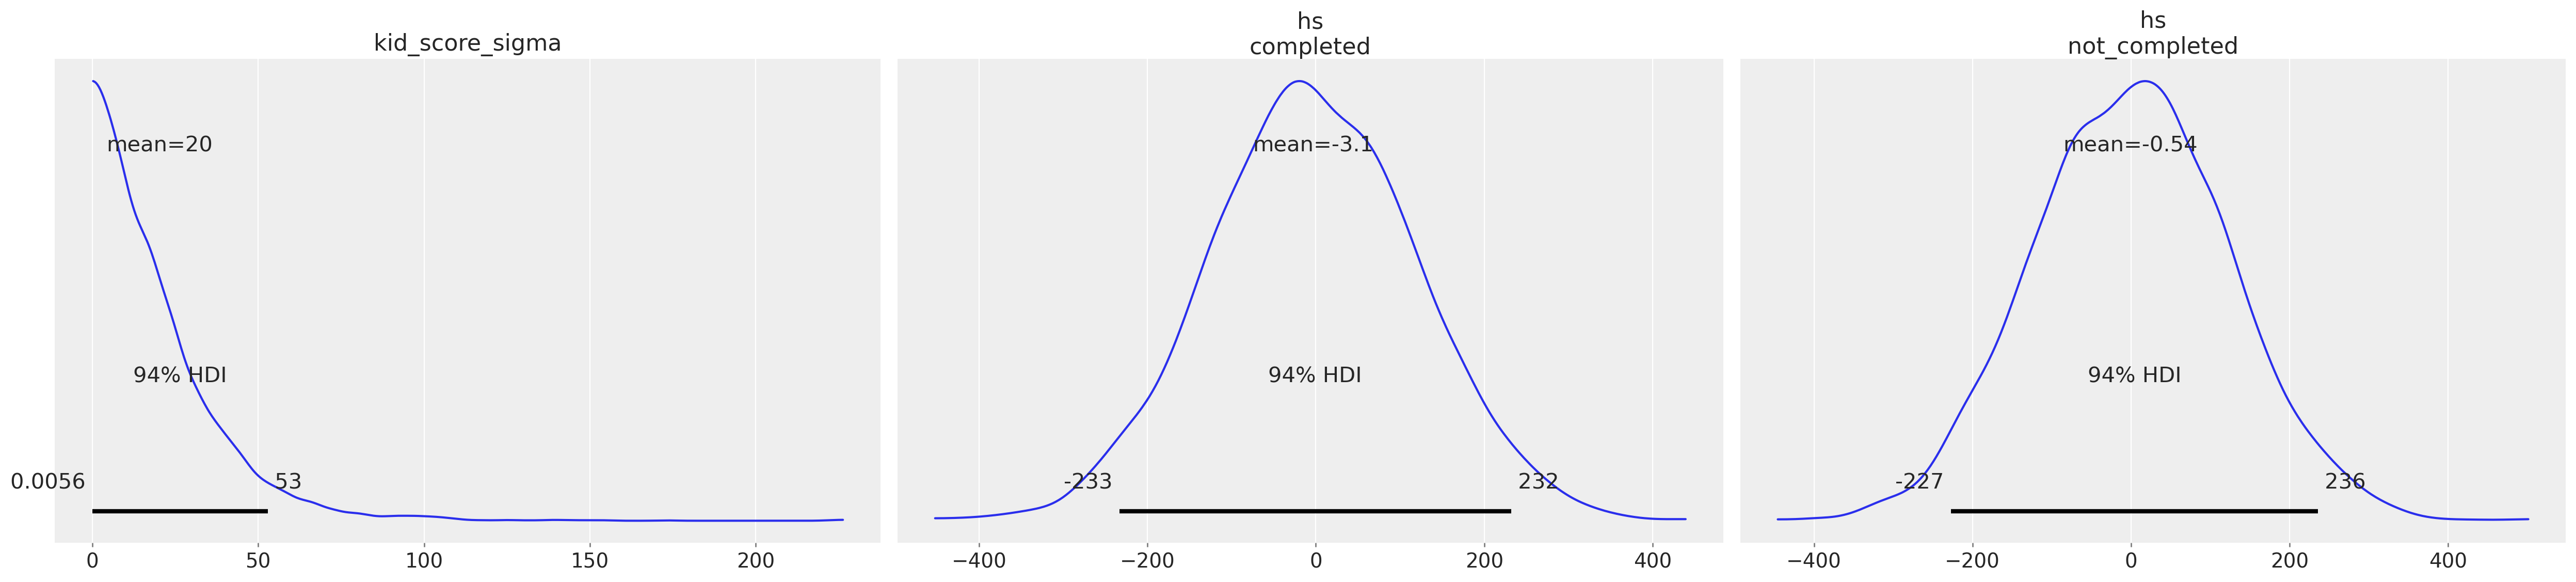

In [46]:
mod_2.plot_priors();

Esaminiamo le distribuzioni a posteriori dei parametri del modello.

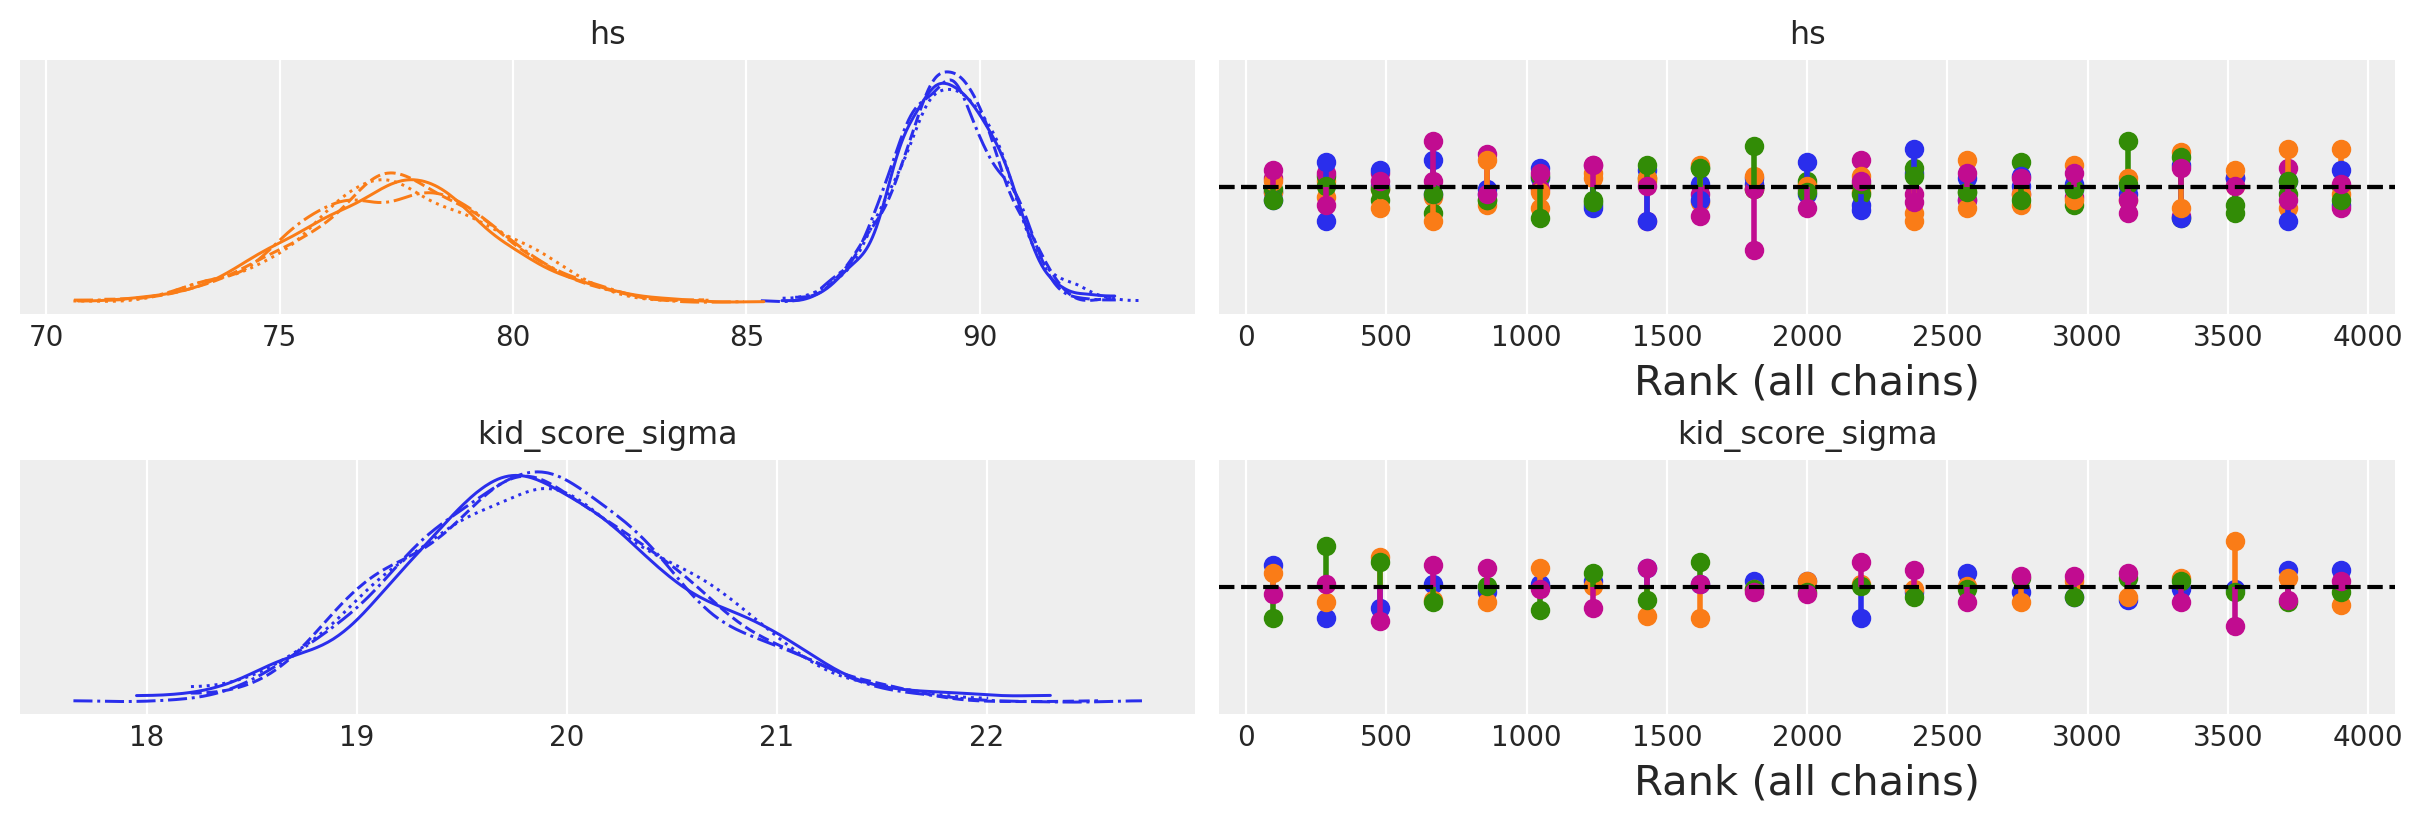

In [47]:
az.plot_trace(results_2, kind="rank_vlines");

In [48]:
az.summary(results_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hs[completed],89.328,1.088,87.389,91.424,0.017,0.012,3895.0,2878.0,1.0
hs[not_completed],77.524,2.099,73.263,81.210,0.033,0.023,4148.0,2864.0,1.0
kid_score_sigma,19.900,0.672,18.690,21.165,0.011,0.008,3698.0,3067.0,1.0


In questo caso, notiamo che abbiamo ottenuto le distribuzioni a posteriori per i parametri `hs[completed]` e `hs[not_completed]` che corrispondono alle medie dei due gruppi. Tali distribuzioni a posteriori illustrano direttamente l'incertezza sulla media dei due gruppi, alla luce della variabilità campionaria e delle nostre credenze a priori.

Possiamo svolgere il test bayesiano di ipotesi sulla differenza tra le due medie a posteriori nel modo seguente.

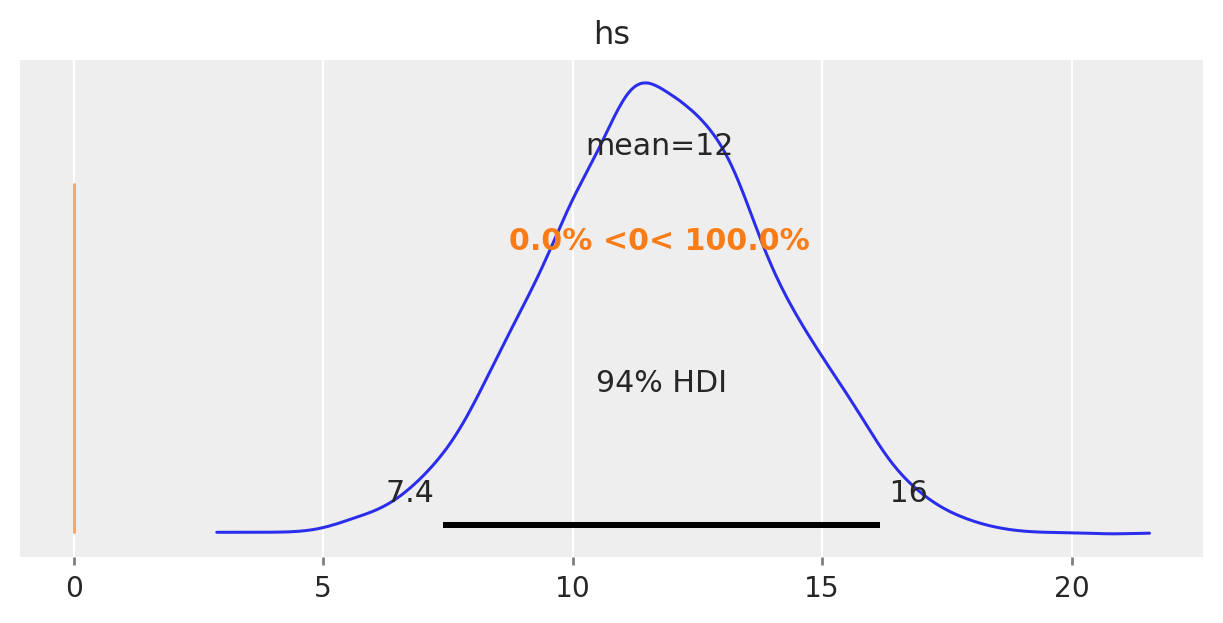

In [22]:
post_group = results_2.posterior["hs"]
diff = post_group.sel(hs_dim="completed") - post_group.sel(hs_dim="not_completed")
az.plot_posterior(diff, ref_val=0, figsize=(6, 3));

In [53]:
# Probabiliy that posterior is > 0
(post_group > 0).mean().item()

1.0

I risultati sono ovviamente identici a quelli trovati in precedenza.

## Analisi con PyMC

Per completezza, ripetiamo l'analsi specificando il modello bayesiano con PyMC.

In [14]:
μ_m = kidiq.kid_score.mean()
μ_s = kidiq.kid_score.std() * 3

with Model() as model:
    # Priors
    alpha = Normal("alpha", mu=μ_m, sigma=μ_s)
    beta = Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=30)
    # Expected value of outcome
    mu = alpha + beta * kidiq["mom_hs"] 
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=kidiq["kid_score"])

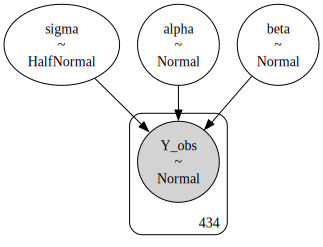

In [59]:
pm.model_to_graphviz(model)

Esaminiamo la distribuzione predittia a priori.

In [15]:
with model:
    prior_samples = pm.sample_prior_predictive(1000)

Sampling: [Y_obs, alpha, beta, sigma]


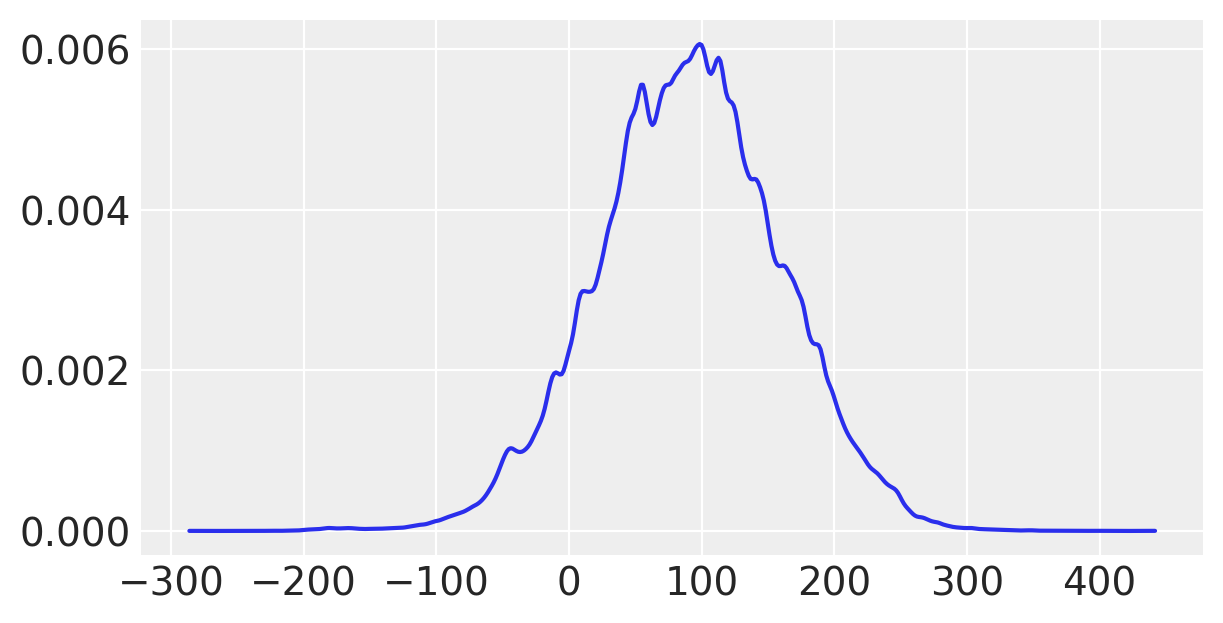

In [16]:
az.plot_dist(prior_samples.prior_predictive["Y_obs"], figsize=(6, 3));

Eseguiamo il campionamento.

In [62]:
with model:
    trace = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:02.223548
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:06<?, ?it/s]




Running chain 0:  50%|█████     | 1000/2000 [00:06<00:00, 9358.21it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:06<00:00, 303.93it/s] 
Sampling time = 0:00:06.873854
Transforming variables...
Transformation time = 0:00:00.144195


Esaminiamo i risultati.

In [63]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,78.02,2.04,74.26,81.97,0.05,0.04,1490.79,1610.40,1.00
beta,11.17,2.28,7.01,15.59,0.06,0.04,1537.62,1890.30,1.00
sigma,19.90,0.70,18.66,21.23,0.02,0.01,1977.67,2020.57,1.01


I risultati replicano quelli ottenuti in precedenza.

Aggiungiamo al modello bayesiano la stima della grandezza dell'effetto.

In [18]:
with Model() as model:
    # Priors
    alpha = Normal("alpha", mu=μ_m, sigma=μ_s)
    beta = Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=30)
    # Expected value of outcome
    mu = alpha + beta * kidiq["mom_hs"] 
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=kidiq["kid_score"])
    
    effect_size = pm.Deterministic("effect size", beta / sigma)
    
    trace = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time = 0:00:00.435332
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1205.48it/s]
Sampling time = 0:00:01.739862
Transforming variables...
Transformation time = 0:00:00.048638


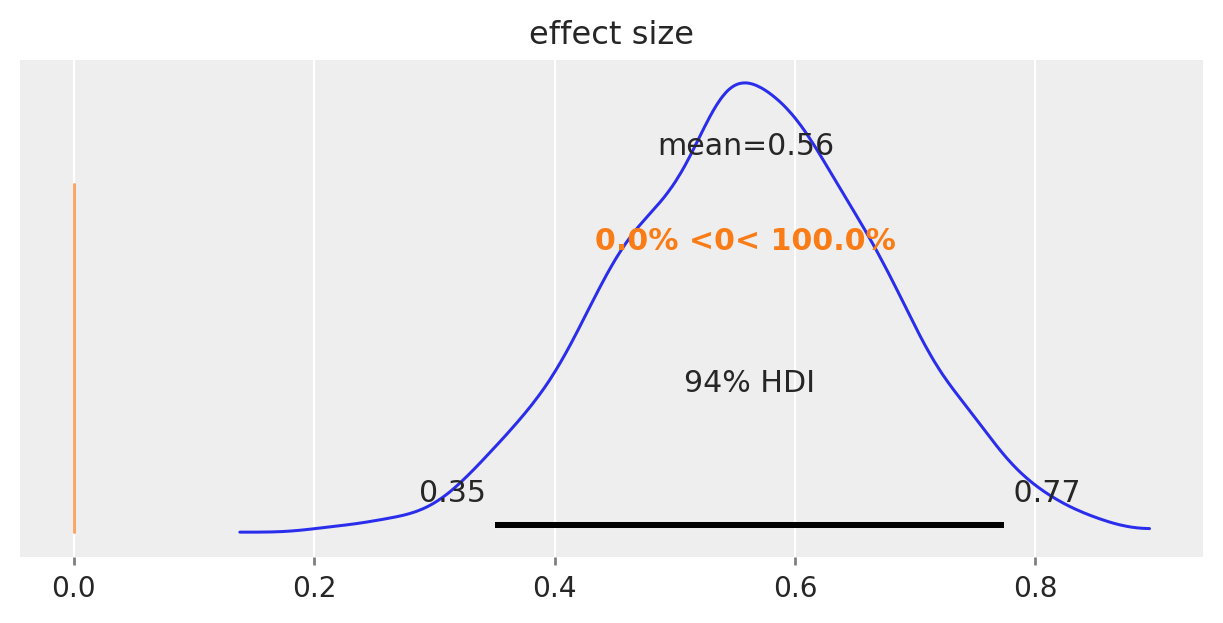

In [19]:
az.plot_posterior(trace, ref_val=0, var_names=["effect size"], figsize=(6, 3));

In [66]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,78.06,2.10,74.34,82.10,0.05,0.04,1613.15,1524.32,1.0
beta,11.14,2.34,6.92,15.32,0.06,0.04,1720.36,1747.00,1.0
sigma,19.89,0.68,18.67,21.19,0.02,0.01,1786.37,1775.60,1.0
effect size,0.56,0.12,0.34,0.78,0.00,0.00,1660.74,1662.20,1.0


Anche in questo caso i risultati replicano quelli ottenuti in precedenza.

## Watermark

In [67]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Nov 08 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

pytensor: 2.13.1

pandas    : 2.1.1
pymc      : 5.9.1
matplotlib: 3.8.0
numpy     : 1.25.2
scipy     : 1.11.3
bambi     : 0.12.0
seaborn   : 0.13.0
arviz     : 0.16.1

Watermark: 2.4.3

